In [1]:
import pandas as pd
import requests
import numpy as np
import json
idx = pd.IndexSlice
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import sqlite3
import os

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams.update({'font.size': 22})
plt.style.use('seaborn-poster')
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.bottom'] = False

# 1. Download CPI data

## 1.A Download CPI
- [API documentation](https://www.e-stat.go.jp/api/api-info/e-stat-manual3-0#api_2_3)
- [CPI data explorer](https://www.e-stat.go.jp/dbview?sid=0003427113)

### 1.A.1 Import api key
- You must apply for an api key in Japanese 
    - [Link](https://www.e-stat.go.jp/en/developer)

In [2]:
api_file = open('api_key.txt')
api_code = "".join(api_file.readlines())

In [3]:
def download_series(series_id, time_from, time_to):
    url = f'http://api.e-stat.go.jp/rest/3.0/app/json/getStatsData?appId={api_code}&statsDataId={series_id}&cdTab=1&cdArea=00000&cdTimeFrom={time_from}&cdTimeTo={time_to}&metaGetFlg=Y&cntGetFlg=N&explanationGetFlg=Y&annotationGetFlg=Y&sectionHeaderFlg=1&replaceSpChars=0'
    r = requests.get(url)
    json_data = json.loads(r.text)
    return json_data

## 1.1 Import  CPI: 2013~2022

In [4]:
res = download_series('0003427113', '2013', '2022')
if res['GET_STATS_DATA']['RESULT']['ERROR_MSG'] == '正常に終了しました。':
    print('Download successfull')

Download successfull


### 1.1.1 Convert to df
#### 1.1.1.A Convert function

In [5]:
def convert_pandas(json_data):
    data_dict = []
    for data in json_data['GET_STATS_DATA']['STATISTICAL_DATA']['DATA_INF']['VALUE']:
   
        data_dict.append([data['@area'], data['@time'], data['@cat01'], data['$']])
    
    df = pd.DataFrame(data_dict)
    
    df.columns = ['region','date','category','value']
    df.date = [x[:4] + '-' + x[-2:] + '-01'  for x in df.date]
    
    mask = []
    for x in df.date:
        if '-00-' in x:
            mask.append(False)
        else:
            mask.append(True)
    
    df = df.loc[mask,:]
    df.date = pd.to_datetime(df.date)
    df.value = df.value.astype(float)
    df.set_index(['region','date'], inplace=True)

    return df

#### 1.1.1.1 Download

In [6]:
df_2012 = convert_pandas(res)
df_2012.head(2)

category  value
region date                      
00000  2021-12-01     0001  100.1
       2021-11-01     0001  100.1

#### 1.1.1.2 Check

In [7]:
print(f"Categories: {len(df_2012.category.unique())} \nTotal observations: {len(df_2012)}")

Categories: 790 
Total observations: 80941


## 1.2 Import  CPI: 2003~2012

In [8]:
res = download_series('0003427113', '2003', '2012')
if res['GET_STATS_DATA']['RESULT']['ERROR_MSG'] == '正常に終了しました。':
    print('Download successfull')

Download successfull


### 1.2.1 Conver to df

In [9]:
df_2003 = convert_pandas(res)
df_2003.head(2)

category  value
region date                      
00000  2011-12-01     0001   94.3
       2011-11-01     0001   94.2

## 1.3 Merge

In [10]:
df = pd.concat([df_2012, df_2003], axis=0)
df.head(2)

category  value
region date                      
00000  2021-12-01     0001  100.1
       2021-11-01     0001  100.1

## 1.B Data dicts


### 1.B.1 Categories

In [11]:
res = download_series('0003427113', '2020', '2020')
dict_cats ={}
for item in res['GET_STATS_DATA']['STATISTICAL_DATA']['CLASS_INF']['CLASS_OBJ']:
    if item['@id']=='cat01':
        for code in item['CLASS']:
            dict_cats.update({code['@code'] : code['@name']})

#### 1.B.1 Show categories

In [12]:
def dict_slice(dic, values):
    return {k: dic[k] for k in list(dic)[:values]}

In [13]:
dict_slice(dict_cats,5)

{'0001': '0001 総合',
 '0002': '0002 食料',
 '0003': '0003 穀類',
 '0004': '0004 米類',
 '1001': '1001 うるち米Ａ'}

## 1.C Map dictionary to change names

In [14]:
df.reset_index(inplace=True)
df.head(2)

,region,date,category,value
0,00000,2021-12-01,0001,100.1
1,00000,2021-11-01,0001,100.1


### 1.C.2 Map categories

In [15]:
df.category = df.category.map(dict_cats)
df.head(2)

,region,date,category,value
0,00000,2021-12-01,0001 総合,100.1
1,00000,2021-11-01,0001 総合,100.1


In [16]:
len(df.category.unique()) == 790

True

#### 1.C.2.1 Remove original code

In [17]:
df[['code', 'name']] = df.category.str.split(" ", expand=True)
df.head(2)

,region,date,category,value,code,name
0,00000,2021-12-01,0001 総合,100.1,0001,総合
1,00000,2021-11-01,0001 総合,100.1,0001,総合


## 1.D Weight data

In [18]:
df_dict = pd.read_excel('Input/Item_wt_translation.xlsx',  dtype={'Item_num': str})
df_dict.rename(columns={'Item_name':'name'}, inplace=True)
df_dict.head(2)

,Item_num,name,Weight,Translation
0,0001,総合,10000,All items
1,0002,食料,2626,Food


In [19]:
missing_cats = [x for x in df.name.unique() if x not in df_dict.name.to_list()]
missing_cats

['総合（季節調整済）',
 '生鮮食品を除く総合（季節調整済）',
 '生鮮食品及びエネルギーを除く総合（季節調整済）',
 '財（季節調整済）',
 'サービス（季節調整済）']

In [20]:
df.loc[df.name.isin(missing_cats), :].head(2)

,region,date,category,value,code,name
80401,00000,2021-12-01,0901 総合（季節調整済）,100.2,0901,総合（季節調整済）
80402,00000,2021-11-01,0901 総合（季節調整済）,100.1,0901,総合（季節調整済）


## 1.E Sub-category data

In [21]:
df_subcat = pd.read_excel('Input/Cat_subcomponents.xlsx')
df_subcat = df_subcat.ffill().iloc[:, :-1]
df_subcat.columns = ['Large', 'Middle_1', 'Middle_2', 'Small_1', 'Small_2', 'name']
df_subcat.head(5)

,Large,Middle_1,Middle_2,Small_1,Small_2,name
0,総合,NaN,NaN,NaN,NaN,NaN
1,食料,NaN,NaN,NaN,NaN,NaN
2,食料,NaN,穀類,NaN,NaN,NaN
3,食料,NaN,穀類,NaN,米類,NaN
4,食料,NaN,穀類,NaN,米類,うるち米Ａ


In [22]:
print(f"There are {len(df_subcat['name'].unique())} components of smallest category")

There are 583 components of smallest category


# 1.2 Merge

### 1.2.1 Merge

In [23]:
df_merge = pd.merge(
    df.drop(['region', 'category'], axis=1),
    df_dict.loc[:, ['name','Weight']],
    on = 'name')
#df_merge.set_index(['name', 'date'], inplace=True)
df_merge.head(2)

,date,value,code,name,Weight
0,2021-12-01,100.1,0001,総合,10000
1,2021-12-01,100.1,0001,総合,10000


#### 1.2.1.1 Check data missing from original data set

In [24]:
[x for x in df.name.unique() if x not in df_merge.name.to_list()]

['総合（季節調整済）',
 '生鮮食品を除く総合（季節調整済）',
 '生鮮食品及びエネルギーを除く総合（季節調整済）',
 '財（季節調整済）',
 'サービス（季節調整済）']

In [25]:
print(f'Unique categories after merge: {len(df_merge.name.unique())}\nUnique categories before merge: {len(df.name.unique())}')

Unique categories after merge: 769
Unique categories before merge: 774


#### 1.2.1.2 Check missing weights

In [26]:
missing = df_merge.loc[df_merge.Weight.isna(), :].name.unique()
missing

array([], dtype=object)

In [27]:
df_dict.loc[df_dict.Translation.isin(missing),:]

,Item_num,name,Weight,Translation


### 1.2.2 Add sub-categories

In [28]:
df_merge = pd.merge(df_merge, df_subcat, on ='name', how='outer')
df_merge.head(4)

,date,value,code,name,Weight,Large,Middle_1,Middle_2,Small_1,Small_2
0,2021-12-01,100.1,0001,総合,10000,NaN,NaN,NaN,NaN,NaN
1,2021-12-01,100.1,0001,総合,10000,NaN,NaN,NaN,NaN,NaN
2,2021-11-01,100.1,0001,総合,10000,NaN,NaN,NaN,NaN,NaN
3,2021-11-01,100.1,0001,総合,10000,NaN,NaN,NaN,NaN,NaN


In [29]:
print(f'Unique categories after merge: {len(df_merge.name.unique())}\nUnique categories before merge: {len(df.name.unique())}')

Unique categories after merge: 770
Unique categories before merge: 774


In [30]:
mask = df_merge.code.isna()
df_merge = df_merge.loc[~mask, :]
df_merge.head(2)

,date,value,code,name,Weight,Large,Middle_1,Middle_2,Small_1,Small_2
0,2021-12-01,100.1,0001,総合,10000,NaN,NaN,NaN,NaN,NaN
1,2021-12-01,100.1,0001,総合,10000,NaN,NaN,NaN,NaN,NaN


## 1.3 Add translation column

In [31]:
dict_trans = df_dict.set_index('name').Translation.to_dict()
dict_slice(dict_trans, 3)

{'総合': 'All items', '食料': 'Food', '穀類': 'Cereals'}

## 1.4 Add cpi basket calculation 

In [32]:
df_merge.Weight = df_merge.Weight.replace('- ', np.nan)
df_merge['basket'] = df_merge.value.multiply(df_merge.Weight / 10000)
df_merge.head(2)

,date,value,code,name,Weight,Large,Middle_1,Middle_2,Small_1,Small_2,basket
0,2021-12-01,100.1,0001,総合,10000.0,NaN,NaN,NaN,NaN,NaN,100.1
1,2021-12-01,100.1,0001,総合,10000.0,NaN,NaN,NaN,NaN,NaN,100.1


## 1.5 Check discountinued series

In [33]:
#df_merge.Weight.replace(np.nan, 1)
df_merge.loc[df_merge.Weight.isna(),:].name.unique()

array(['かつお', 'えだまめ', 'しらぬひ', '梨', 'ぶどうＡ', 'ぶどうＢ', '桃', 'すいか', 'メロン',
       'いちご', 'さくらんぼ', '民営家賃（木造）', '民営家賃（非木造）', '持家の帰属家賃（木造）',
       '持家の帰属家賃（非木造）'], dtype=object)

In [34]:
df_merge.loc[df_merge.Weight.isna(),:].groupby('name').first()['date']

name
いちご            2021-12-01
えだまめ           2021-09-01
かつお            2021-10-01
さくらんぼ          2021-07-01
しらぬひ           2021-05-01
すいか            2021-08-01
ぶどうＡ           2021-09-01
ぶどうＢ           2021-10-01
メロン            2021-08-01
持家の帰属家賃（木造）    2021-12-01
持家の帰属家賃（非木造）   2021-12-01
桃              2021-09-01
梨              2021-10-01
民営家賃（木造）       2021-12-01
民営家賃（非木造）      2021-12-01
Name: date, dtype: datetime64[ns]

In [35]:
df_merge.set_index('date', inplace= True)

# 2. Smallest components

## 2.1 Explore data

### 2.1.A.a Check that sub-cats total 10000 (total basket)

In [36]:
# All sub categories have code that does not start with 0
# All categories in other words start with 0

mask = [float(x[0])>=1 for x in df_merge.code]
sub_cats_small = df_merge.loc[mask, :]
sub_cats_small.head(2)

,value,code,name,Weight,Large,Middle_1,Middle_2,Small_1,Small_2,basket
date,,,,,,,,,,
2021-12-01,93.6,1001,うるち米Ａ,23.0,食料,NaN,穀類,NaN,米類,0.21528
2021-11-01,94.4,1001,うるち米Ａ,23.0,食料,NaN,穀類,NaN,米類,0.21712


In [37]:
print('There are {} sub categories'.format(len(sub_cats_small.name.unique())))

There are 582 sub categories


In [38]:
sum_all = sub_cats_small.loc['2021-11-01',['name', 'Weight']].sort_values('Weight', ascending=False).drop_duplicates().Weight.sum()

print(f"Sub-cats total {sum_all} of total 10000")

Sub-cats total 9998.0 of total 10000


### 2.1.A Show largest weights

In [39]:
sub_cats_small_wt = sub_cats_small.loc[
    '2021-11-01'].loc[:,
                      ['name', 'Weight']].sort_values(
    'Weight', 
    ascending=False).drop_duplicates().reset_index(drop=True).set_index(
    'name').divide(10000).multiply(100)


In [40]:
sub_cats_small_wt_index = sub_cats_small_wt.head(20).index
sub_cats_small_wt.index =  sub_cats_small_wt.index.map(dict_trans)
sub_cats_small_wt.head()

,Weight
name,
Imputed rent,15.80
Electricity,3.41
Telephone charges (mobile phone),2.71
Medical treatment,2.29
"House rent, private",2.25


In [41]:
#sub_cats_small_wt.to_excel('Output/Charts/cpi_small_wt.xlsx')

### 2.1.B Calculate contribution to inflation

In [42]:
sub_cats_small = sub_cats_small.drop(['code'], 
                               axis=1).reset_index().pivot_table(
    columns='name', 
    index='date', 
    values='basket').diff(12).dropna(how='all')
#sub_cats_small.columns = sub_cats_small.columns.map(dict_trans)

sub_cats_small.head(3)

name,あさり,あじ,あんパン,いか,いくら,いわし,うどん（外食）,うなぎかば焼き,うるち米Ａ,うるち米Ｂ,...,高速バス代,高速自動車国道料金,魚介つくだ煮,魚介漬物,魚介缶詰,鶏卵,鶏肉,鼻炎薬,ＰＴＡ会費（中学校）,ＰＴＡ会費（小学校）
date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,0.00069,0.00060,-0.00175,0.00072,NaN,-0.00004,0.0,-0.00063,0.06463,0.09906,...,NaN,0.0,-0.00032,-0.00110,-0.00220,-0.01850,-0.00405,NaN,0.00048,0.0
2004-02-01,0.00036,0.00104,-0.00140,0.00018,NaN,-0.00012,0.0,-0.00144,0.06371,0.10374,...,NaN,0.0,0.00052,0.00143,0.00088,-0.02025,-0.00135,NaN,0.00048,0.0
2004-03-01,0.00063,-0.00012,-0.00315,-0.00228,NaN,-0.00124,0.0,-0.00036,0.05704,0.09321,...,NaN,0.0,0.00084,-0.00341,-0.00066,-0.01950,-0.00225,NaN,0.00048,0.0


### 2.1.C Calculate inflation y-o-y

In [43]:
mask = [float(x[0])>=1 for x in df_merge.code]
sub_cats_small_pct = df_merge.loc[mask, :]
sub_cats_small_pct = sub_cats_small_pct.drop(['code'], 
                               axis=1).reset_index().pivot_table(
    columns='name', 
    index='date', 
    values='value').pct_change(12).multiply(100).dropna(how='all')



## 2.1 Cars

<AxesSubplot:xlabel='date'>

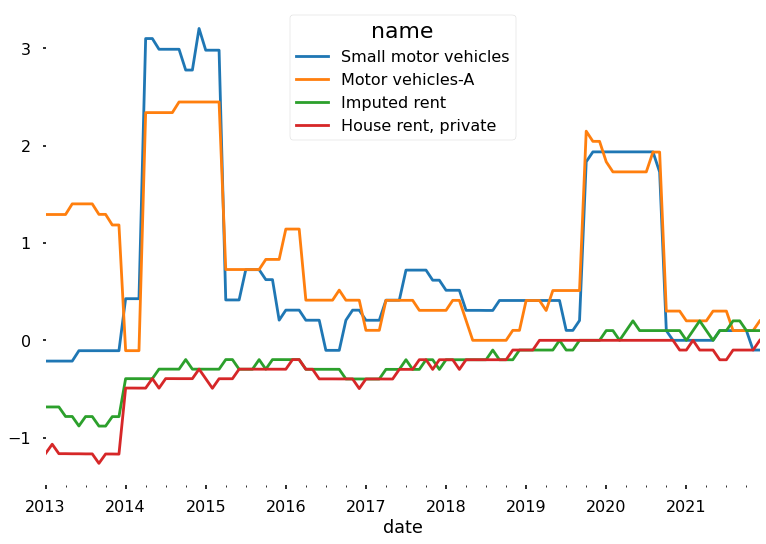

In [44]:
sub_cats_small_pct_graph = sub_cats_small_pct.loc['2012':, 
                                                  ['小型乗用車', '普通乗用車Ａ', '持家の帰属家賃', '民営家賃']].dropna()
sub_cats_small_pct_graph.columns = sub_cats_small_pct_graph.columns.map(dict_trans)
sub_cats_small_pct_graph.plot()

## 2.2 Contribution to inflation: Largest weights by smallest components

### 2.2.A Function for time series bar graph

In [45]:
def graph_bar(df, from_date=False):
    
    df.columns = df.columns.map(dict_trans)
    #df.to_csv(f'Output/Charts/{out_file}.csv')
    ax = df.loc[from_date:, :].plot(kind='bar', stacked=True)
    labels = [x.strftime('%b-%Y') for x in df.loc[from_date:, :].index]
    plt.xticks(rotation = 45)
    ax.set_xticklabels(labels)
    ax.set_xticks(ax.get_xticks()[::6])
    ax.axhline(0, color = 'red')
    plt.legend(loc = 'lower center', 
               frameon=False,
           ncol=3,
           bbox_to_anchor=(0.5, -0.47))

### 2.2.1 Graph

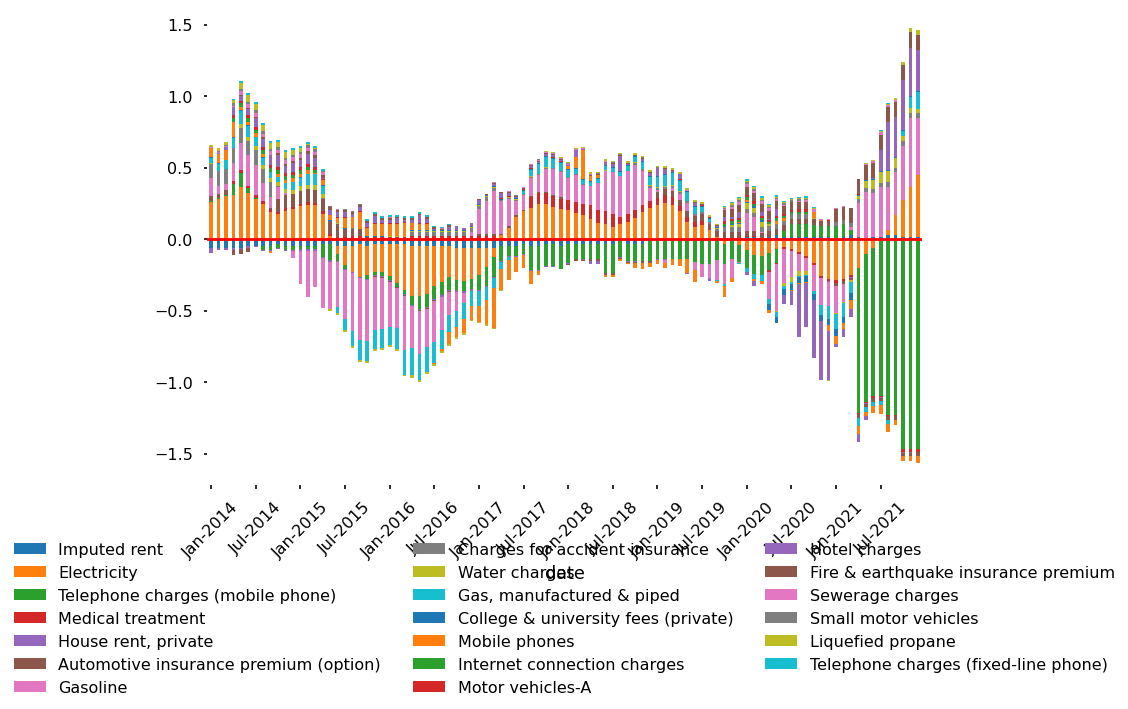

In [46]:
graph_bar(df = sub_cats_small.loc[:, sub_cats_small_wt_index], 
          from_date = '2014')

## 2.3 Recent drivers of inflation

Text(0.5, 1.0, 'Contribution to inflation: smallest component groups')

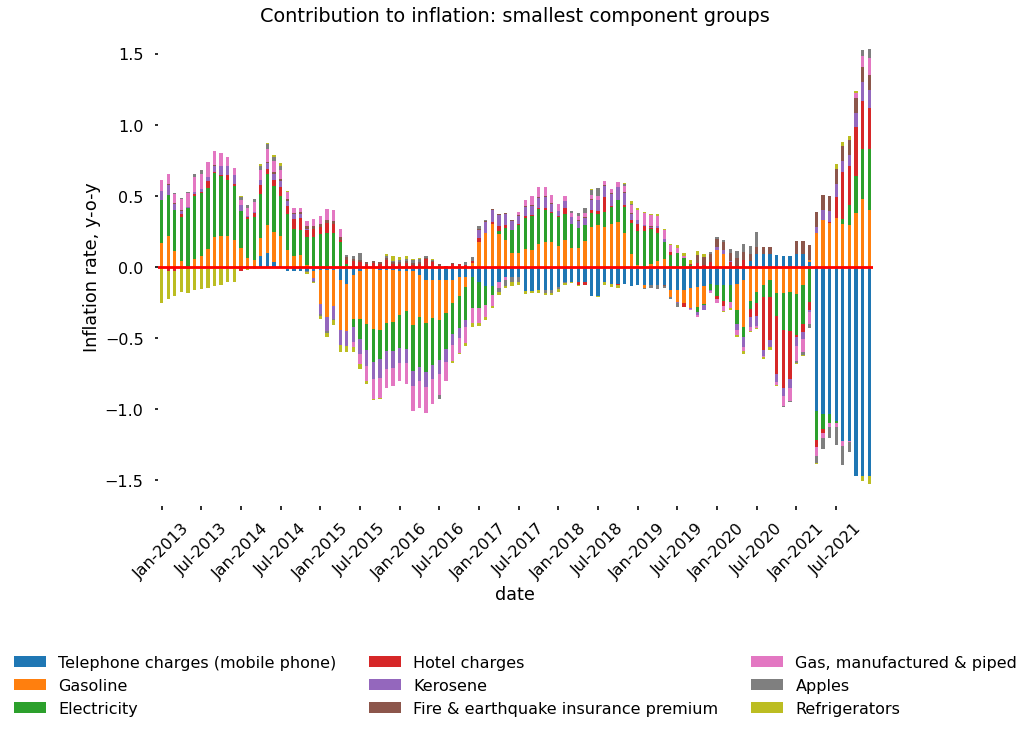

In [47]:
#most_influential_all = sub_cats_small.transform(abs).mean(axis=0).sort_values(ascending=False).index[:9]
most_influential_all = sub_cats_small.loc['2021-11-01'].apply(abs).sort_values(ascending=False).index[:9]

graph = sub_cats_small.loc[:, most_influential_all]

graph_bar(graph, 
          from_date = '2012')
plt.ylabel('Inflation rate, y-o-y')
plt.title('Contribution to inflation: smallest component groups')

## 2.4 Diffusion index

### 2.4.A Create new table with y-o-y changes

In [48]:
mask = [float(x[0])>=1 for x in df_merge.code]
sub_cats_small_value = df_merge.loc[mask, :].drop(['code'], 
                               axis=1).reset_index().pivot_table(
    columns='name', 
    index='date', 
    values='value').pct_change(12).multiply(100).dropna(how='all')
sub_cats_small_value.columns = sub_cats_small_value.columns.map(dict_trans)

sub_cats_small_value.head(3)

name,Short-necked clams,Horse mackerel,Bean-jam buns,Cuttlefish,Salmon roe,Strawberries,Sardines,"“Udon”, Japanese noodles (eating out)","“Kabayaki”, broiled eels",Non-glutinous rice-A,...,Expressway bus fares,National expressway tolls,Fish prepared in soy sauce,Pickled fish,Canned fish,Hen eggs,Chicken,Medicines for rhinitis,PTA membership fees (junior high school),PTA membership fees (elementary school)
date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,2.878598,1.497006,-0.593824,2.339181,NaN,-5.896806,-0.323102,0.0,-1.569507,26.609848,...,NaN,0.0,-1.079622,-1.449275,-2.518892,-9.919571,-1.068884,NaN,0.406918,0.0
2004-02-01,1.517067,2.733964,-0.473934,0.597610,NaN,9.102731,-0.966184,0.0,-3.539823,26.231061,...,NaN,0.0,1.780822,1.900585,1.034929,-10.188679,-0.356295,NaN,0.406918,0.0
2004-03-01,2.651515,-0.294118,-1.065089,-6.270627,NaN,0.691563,-9.725490,0.0,-0.900901,23.551757,...,NaN,0.0,2.888583,-4.466859,-0.763359,-9.811321,-0.595238,NaN,0.406918,0.0


### 2.4.1 Sub-components above 0

In [49]:
sub_cats_small_value['2016':].transform(lambda x: x > 0).astype(float).sum(axis=1).head(3)

date
2016-01-01    344.0
2016-02-01    364.0
2016-03-01    377.0
dtype: float64

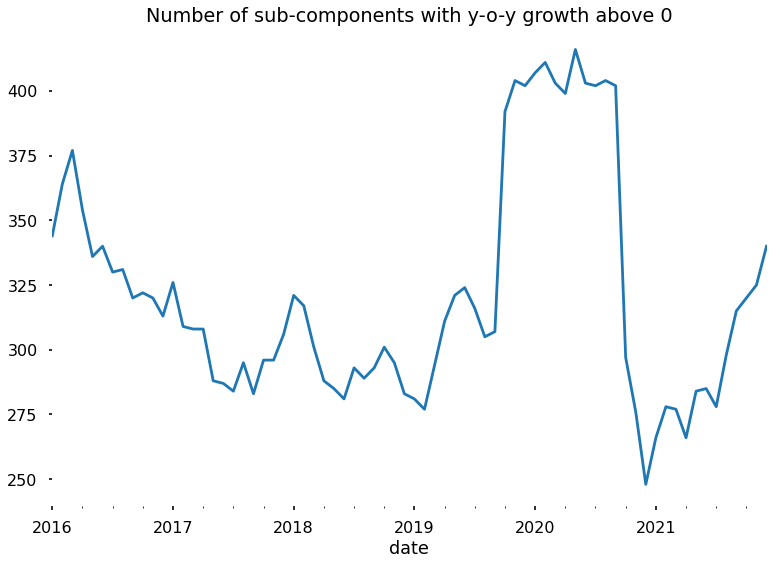

In [50]:
sub_cats_small_value['2016':].transform(lambda x: x > 0).astype(float).sum(axis=1).plot()
plt.title('Number of sub-components with y-o-y growth above 0');

### 2.4.2 Mean standard deviation of all items

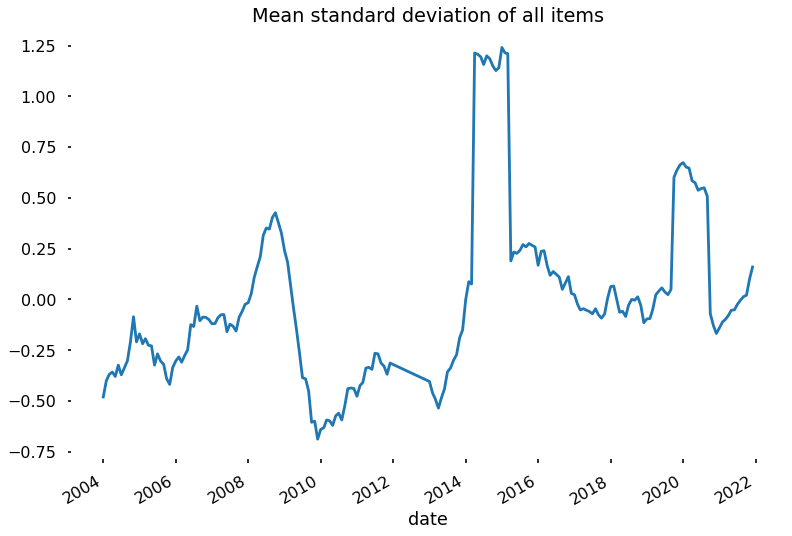

In [51]:
sub_cats_small_value.transform(lambda x: (x-x.mean())/ x.std()).mean(axis=1).plot()
plt.title('Mean standard deviation of all items');

## 2.5 Increasing items by category

### 2.5.A Create large category map 

In [54]:
# Re-import data
mask = [float(x[0])>=1 for x in df_merge.code]
sub_cats_small = df_merge.loc[mask, :]
sub_cats_small_value = sub_cats_small.drop(['code'], 
                               axis=1).reset_index().pivot_table(
    columns='name', 
    index='date', 
    values='value').pct_change(12).multiply(100).dropna(how='all')
# Re-import data




item_cat_dict = sub_cats_small.loc[:, 
                                   ['name', 'Large']].reset_index(drop = True).set_index('name').Large.to_dict()
dict_slice(item_cat_dict, 4)

{'うるち米Ａ': '食料', 'うるち米Ｂ': '食料', '食パン': '食料', 'あんパン': '食料'}

### 2.5.1 Count number of positive groups for each date

In [55]:
dict_final = {}
for date in sub_cats_small_value.index:
    cats_grow = sub_cats_small_value.loc[date].sort_values(ascending=False).apply(lambda x: x>0)
    cats_grow = cats_grow.loc[cats_grow==True].index
    counts = cats_grow.map(item_cat_dict).value_counts().to_dict()
    counts = {date: counts}
    #print(counts)
    dict_final.update(counts)
df_counts = pd.DataFrame(dict_final).transpose().dropna().iloc[:, :-1]
df_counts.columns = df_counts.columns.map(dict_trans)
df_counts.tail(2)

,Food,Culture & recreation,Clothes & footwear,Miscellaneous,Education,Furniture & household utensils,Housing,Transportation & communication,Medical care,"Fuel, light & water charges"
2021-11-01,129.0,43.0,33.0,22.0,10.0,29.0,17.0,20.0,15.0,6.0
2021-12-01,140.0,43.0,32.0,25.0,10.0,26.0,19.0,22.0,16.0,6.0


### 2.5.2 Graph

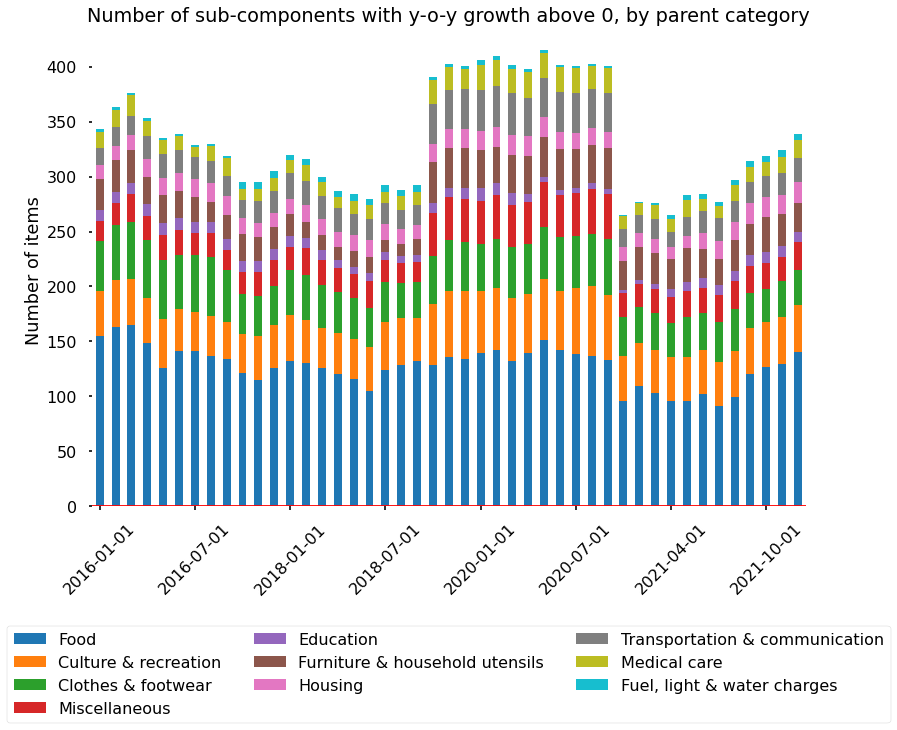

In [56]:
ax = df_counts.plot(kind='bar', stacked=True)

labels = [x.strftime('%Y-%m-%d') for x in df_counts.index]
plt.xticks(rotation = 45)
ax.set_xticklabels(labels)
ax.set_xticks(ax.get_xticks()[::6])
ax.axhline(0, color = 'red')
plt.legend(loc = 'lower center', 
           ncol=3,
           bbox_to_anchor=(0.5, -0.47))
plt.ylabel('Number of items ')
plt.title('Number of sub-components with y-o-y growth above 0, by parent category');

# 3. Largest components

## 3.A Subset data

In [57]:
df_subcat = pd.read_excel('Input/Cat_subcomponents.xlsx')
#df_subcat = df_subcat.ffill().iloc[:, :-1]
df_subcat = df_subcat.iloc[:, :-1]

df_subcat.columns = ['Large', 'Middle_1', 'Middle_2', 'Small_1', 'Small_2', 'name']
df_subcat.head(3)

,Large,Middle_1,Middle_2,Small_1,Small_2,name
0,総合,NaN,NaN,NaN,NaN,NaN
1,食料,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,穀類,NaN,NaN,NaN


In [58]:
mask = [x for x in df_subcat.Large.dropna().unique() if '総合' not in x and '除く' not in x and '再掲' not in x and '財' not in x and 'サービス' not in x and '教養娯楽' not in x and  '家賃' not in x ]
mask.remove('教育')
mask.remove('米類')
mask = df_merge.name.isin(mask)
df_merge.loc[mask, :].loc['2021-11-01'].name.unique()

array(['食料', '住居', '光熱・水道', '家具・家事用品', '被服及び履物', '保健医療', '交通・通信', '諸雑費',
       '生鮮食品', 'エネルギー', '教育関係費', '情報通信関係費', '公共料金'], dtype=object)

In [59]:
df_cats_lar = df_merge.loc[mask, :]
df_cats_lar.head(3)

,value,code,name,Weight,Large,Middle_1,Middle_2,Small_1,Small_2,basket
date,,,,,,,,,,
2021-12-01,100.9,0002,食料,2626.0,NaN,NaN,NaN,NaN,NaN,26.49634
2021-11-01,100.8,0002,食料,2626.0,NaN,NaN,NaN,NaN,NaN,26.47008
2021-10-01,100.8,0002,食料,2626.0,NaN,NaN,NaN,NaN,NaN,26.47008


### 3.A.1 Show largest weights

In [60]:
sub_cats_large_wt = df_merge.loc[mask, :].loc['2021-11-01'].sort_values('Weight',
                                                    ascending=False).set_index('name').loc[:, ['Weight']]
sub_cats_large_wt_index = sub_cats_large_wt.index
sub_cats_large_wt.index =  sub_cats_large_wt.index.map(dict_trans)
sub_cats_large_wt = sub_cats_large_wt.divide(10000).multiply(100)
sub_cats_large_wt.drop_duplicates().sort_values('Weight', ascending=False)


,Weight
name,
Food,26.26
Housing,21.49
Public utilities charges,17.93
Transportation & communication,14.93
Energy (b),7.12
"Fuel, light & water charges",6.93
Miscellaneous,6.07
Expenses for information & communication,5.00
Medical care,4.77


## 3.1 Contribution to Inflation
### 3.1.1 Create data

- Using .diff() rather than pct_change: Show contributions

In [61]:
sub_cats_large = df_merge.pivot_table(
    columns='name', 
    index='date', 
    values='basket').diff(12).dropna(how='all').loc[:, sub_cats_large_wt_index].drop('情報通信関係費', axis=1)
sub_cats_large.head(3)

name,食料,住居,公共料金,交通・通信,エネルギー,光熱・水道,諸雑費,保健医療,生鮮食品,家具・家事用品,教育関係費,被服及び履物
date,,,,,,,,,,,,
2004-01-01,-0.02626,-0.04298,0.17930,-0.08958,0.02136,0.02079,0.07891,0.16218,-0.10296,-0.14706,0.01134,-0.04942
2004-02-01,0.18382,-0.02149,0.16137,-0.13437,0.00712,0.01386,0.08498,0.16695,0.01188,-0.15867,0.01134,-0.03177
2004-03-01,0.15756,-0.02149,0.16137,-0.17916,-0.02848,0.01386,0.06677,0.16218,-0.02376,-0.14706,0.01134,-0.02471


### 3.1.2 Graph

Text(0.5, 1.0, 'Drivers of inflation, largest components')

<Figure size 384.1x400 with 0 Axes>

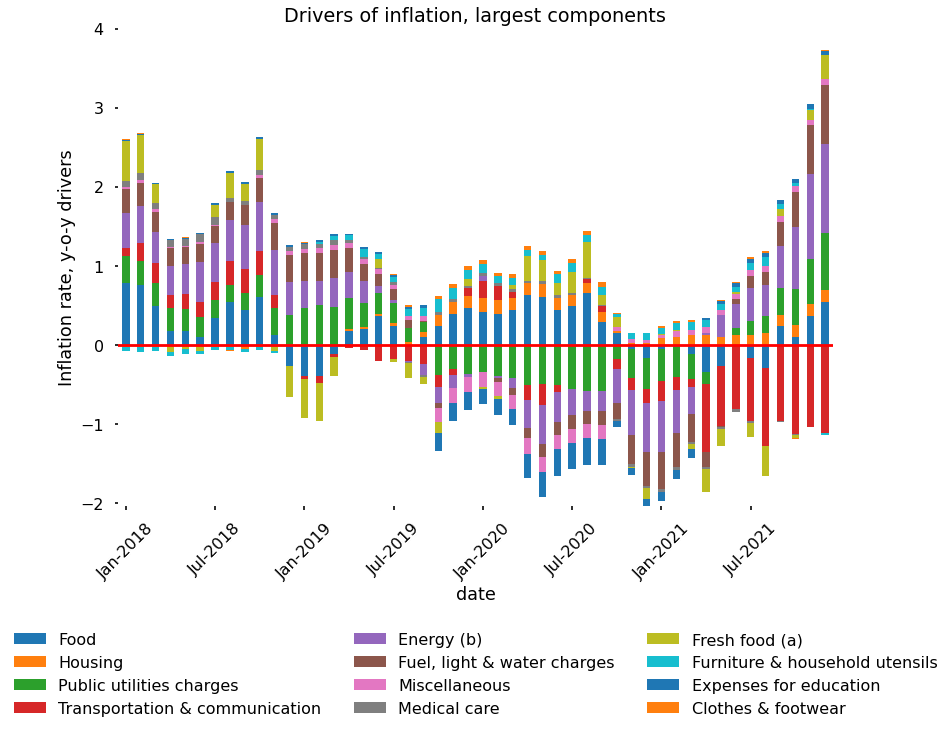

In [62]:
plt.figure(figsize=(3.841, 4), dpi=100)

graph_bar(sub_cats_large, 
          from_date = '2018')
plt.ylabel('Inflation rate, y-o-y drivers')

plt.title('Drivers of inflation, largest components')
#plt.savefig('Output/Figures/Drivers_largest.eps', format= 'eps', dpi=1000, bbox_inches='tight')

## 3.2 Category change y-o-y

### 3.2.1 Create data

In [63]:
sub_cats_large_pct = df_merge.pivot_table(
    columns='name', 
    index='date', 
    values='value').pct_change(12).multiply(100).dropna(how='all').loc[:, sub_cats_large_wt_index].drop('情報通信関係費', axis=1)
sub_cats_large_pct.head(3)

name,食料,住居,公共料金,交通・通信,エネルギー,光熱・水道,諸雑費,保健医療,生鮮食品,家具・家事用品,教育関係費,被服及び履物
date,,,,,,,,,,,,
2004-01-01,-0.115473,-0.197239,1.085776,-0.605449,0.385109,0.369914,1.484018,3.590285,-3.241895,-3.081914,0.28436,-1.567749
2004-02-01,0.811124,-0.098619,0.978261,-0.908174,0.128041,0.246305,1.598174,3.695882,0.382653,-3.330626,0.28436,-1.030928
2004-03-01,0.696056,-0.098619,0.976139,-1.204819,-0.508259,0.246305,1.252847,3.590285,-0.767263,-3.096985,0.28463,-0.778643


## 3.3 Compare y-o-y to contributions

In [64]:
sub_cats_large_pct = df_merge.pivot_table(
    columns='name', 
    index='date', 
    values='value').pct_change(12).multiply(100).dropna(how='all').loc[:, sub_cats_large_wt_index].drop('情報通信関係費', axis=1)

sub_cats_large = df_merge.pivot_table(
    columns='name', 
    index='date', 
    values='basket').diff(12).dropna(how='all').loc[:, sub_cats_large_wt_index].drop('情報通信関係費', axis=1)

df_subcats = pd.concat([sub_cats_large_pct.iloc[-1],
           sub_cats_large.iloc[-1]], axis=1)
df_subcats.columns = ['y-o-y (drivers)', 'y-o-y (change)']
df_subcats

,y-o-y (drivers),y-o-y (change)
name,,
食料,2.125506,0.55146
住居,0.700000,0.15043
公共料金,4.060914,0.71720
交通・通信,-7.407407,-1.10482
エネルギー,16.388309,1.11784
光熱・水道,11.214953,0.74844
諸雑費,1.296112,0.07891
保健医療,-0.100604,-0.00477
生鮮食品,8.038585,0.29700


# 4. Other metrics

## 4.1 Goods versus services

In [65]:
df_cats_lar = df_merge.copy()
df_cats_lar = df_cats_lar.reset_index().pivot_table(
    columns='name', 
    index='date', 
    values='basket').diff(12).dropna(how='all')

df_cats_lar = df_cats_lar.loc[:, ['財', 'サービス']
                             ]
df_cats_lar.columns = df_cats_lar.columns.map(dict_trans)
df_cats_lar['Total'] = df_cats_lar['Goods'] + df_cats_lar['Services']
df_cats_lar.index = df_cats_lar.index.strftime('%b-%Y')
df_cats_lar.tail(2)

name,Goods,Services,Total
date,,,
Nov-2021,1.51380,-0.89172,0.62208
Dec-2021,1.66518,-0.94126,0.72392


<AxesSubplot:xlabel='date'>

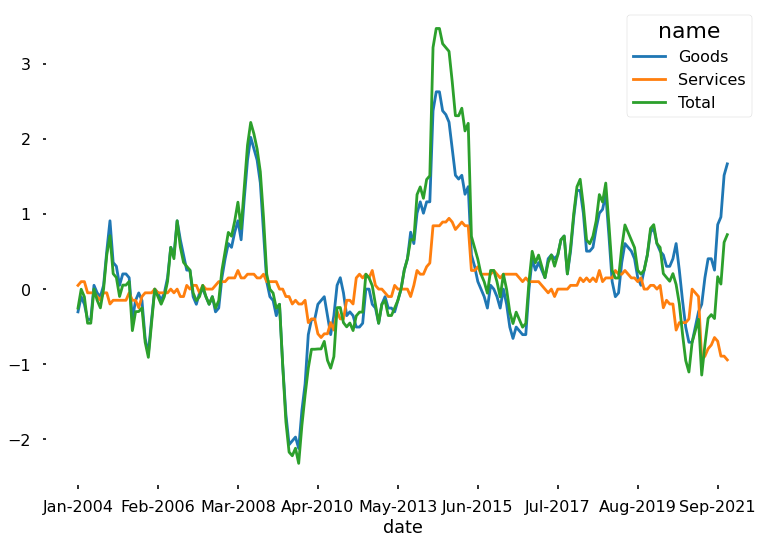

In [66]:
df_cats_lar.plot()

## 4.2 Headline, core, core-core

<AxesSubplot:xlabel='date'>

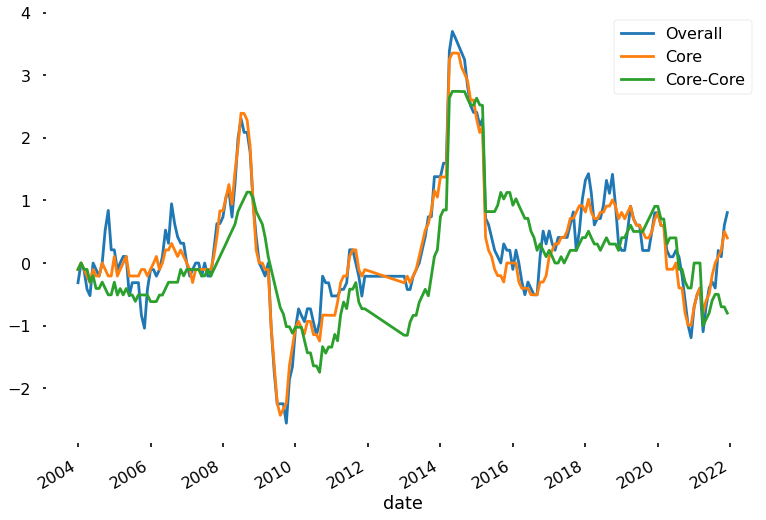

In [67]:
broad = df_merge.pivot_table(
    columns='name', 
    index='date', 
    values='value').pct_change(12).multiply(100).dropna(how='all').loc[:, ['総合', '生鮮食品を除く総合','生鮮食品及びエネルギーを除く総合']]
broad.columns = ['Overall', 'Core', 'Core-Core']
broad.plot()

## 4.3 Housing largest components

<AxesSubplot:xlabel='date'>

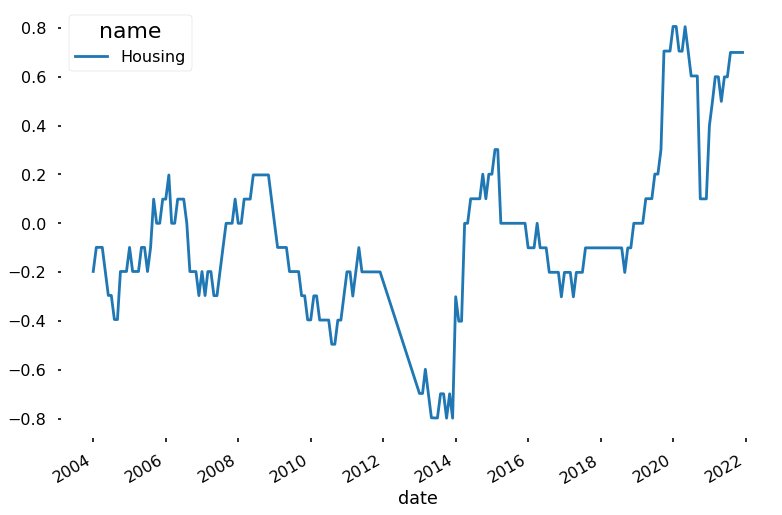

In [68]:
df_cats_lar = df_merge.copy()
df_cats_lar = df_cats_lar.reset_index().pivot_table(
    columns='name', 
    index='date', 
    values='basket').pct_change(12).multiply(100).dropna(how='all')
df_cats_lar = df_cats_lar.loc[:, ['住居']]
df_cats_lar.columns = df_cats_lar.columns.map(dict_trans)
df_cats_lar.plot()